In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import joblib
from pathlib import Path


def load_stock_data(file_path):
    # Φόρτωση του αρχείου CSV σε DataFrame
    df = pd.read_csv(file_path, parse_dates=['date'])

    # Αφαίρεση της στήλης 'complete'
    df.drop(columns=['complete'], inplace=True, errors='ignore')
    
    # Ορισμός της στήλης 'time' ως index
    df.set_index('date', inplace=True)
    
    # Μετονομασία των στηλών
    df.rename(columns={'volume': 'Volume', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)

    return df

def plot_records_distribution(df):
    """
    Δημιουργεί διάγραμμα συχνότητας των εγγραφών για το σύνολο των δεδομένων.
    """
    records_per_day = df.resample('D').size().reset_index()
    records_per_day.columns = ['date', 'count']
    plt.figure(figsize=(12, 6))
    bars = plt.bar(records_per_day['date'], records_per_day['count'], color='blue')
    plt.xlabel('Ημερομηνία')
    plt.ylabel('Πλήθος Εγγραφών')
    plt.title(f'Κατανομή Εγγραφών')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Εμφάνιση του αριθμού εγγραφών πάνω από κάθε μπάρα
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height,
            f'{int(height)}',
            ha='center', va='bottom',
            fontsize=12,      # Μεγαλύτερη γραμματοσειρά
            # rotation=90       # Περιστροφή κειμένου
        )

    plt.tight_layout()
    plt.show()

def plot_stock_prices(df):
    """
    Δημιουργεί διάγραμμα με τις τιμές των μετοχών (κλείσιμο) για το σύνολο του DataFrame.
    Προσθέτει σκίαση ανά ημέρα ή εβδομάδα.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index.to_numpy(), df['Close'].to_numpy(), color='green', linestyle='-', marker='o')
    
    # Προσθήκη σκίασης ανά ημέρα
    for i, date in enumerate(pd.date_range(start=df.index.min(), end=df.index.max())):
        if i % 2 == 0:
            ax.axvspan(date, date + pd.Timedelta(days=1), color='gray', alpha=0.3)
    
    ax.set_xlabel('Ημερομηνία')
    ax.set_ylabel('Τιμή Κλεισίματος')
    ax.set_title(f'Τιμές Κλεισίματος')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
        
def get_stock_data_for_period(df, start_date, end_date, frequency):
    """
    Επιστρέφει τις τιμές των μετοχών για το δοσμένο χρονικό διάστημα με ανάλυση δείγματος σε λεπτά.
    Αν frequency = 0, επιστρέφει τα αρχικά δεδομένα χωρίς δειγματοληψία.
    Αν υπάρχουν άλματα στις ημερομηνίες, ενσωματώνει την πλησιέστερη διαθέσιμη εγγραφή.
    Ενημερώνει την τιμή volume με το άθροισμα όλων των τιμών που παραλήφθηκαν.
    Το low και high είναι το μικρότερο low και το μεγαλύτερο high από τις παραληφθείσες τιμές.
    """
    period_data = df.loc[start_date:end_date].copy()
    
    if frequency == 0:
        return period_data
    
    sampled_data = []
    last_time = None
    temp_group = []
    
    for time, row in period_data.iterrows():
        if last_time is None or (time - last_time).total_seconds() / 60 >= frequency:
            if temp_group:
                sampled_row = temp_group[0].copy()
                sampled_row['Volume'] = sum(r['Volume'] for r in temp_group)
                sampled_row['Low'] = min(r['Low'] for r in temp_group)
                sampled_row['High'] = max(r['High'] for r in temp_group)
                sampled_data.append(sampled_row)
            temp_group = []
            last_time = time
        temp_group.append(row)
    
    if temp_group:
        sampled_row = temp_group[0].copy()
        sampled_row['Volume'] = sum(r['Volume'] for r in temp_group)
        sampled_row['Low'] = min(r['Low'] for r in temp_group)
        sampled_row['High'] = max(r['High'] for r in temp_group)
        sampled_data.append(sampled_row)
    
    return pd.DataFrame(sampled_data)

def monday_two_weeks_ago(date=None):
    if date is None:
        date = datetime.now().date()
    days_since_monday = date.weekday()  # Δευτέρα=0
    last_monday = date - timedelta(days=days_since_monday)
    return last_monday - timedelta(days=14)

def get_train_test_weeks(date=None):
    start_train = monday_two_weeks_ago(date)
    end_train = start_train + timedelta(days=4)
    start_test = start_train + timedelta(days=7)
    end_test = start_test + timedelta(days=4)

    # Μετατροπή σε string
    date_fmt = "%Y-%m-%d"
    return (
        start_train.strftime(date_fmt),
        end_train.strftime(date_fmt),
        start_test.strftime(date_fmt),
        end_test.strftime(date_fmt)
    )


In [ ]:
### Imports
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv, Positions 

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch
import quantstats as qs
from ta import add_all_ta_features
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def my_render(env, df2=None, start_index=None, end_index=None, title=None):
    # Extract the price series for the episode
    prices = df2['Close'][0:end_index].values
    window_ticks = np.arange(len(prices))
    position_history = env._position_history
    window_size = env.window_size
    trade_fee = env.trade_fee if hasattr(env, 'trade_fee') else 0.0

    # Identify all trade points (count any position change as a trade)
    trade_ticks = []
    short_ticks = []
    long_ticks = []
    shorts = longs = 0
    # for i, tick in enumerate(window_ticks):
    for i, tick in enumerate(window_ticks):
        if env._position_history[i] == Positions.Short and env._position_history[i-1] != Positions.Short:
            trade_ticks.append(tick)
            short_ticks.append(tick)
            shorts+=1
        elif env._position_history[i] == Positions.Long and env._position_history[i-1] != Positions.Long:
            trade_ticks.append(tick)
            long_ticks.append(tick)
            longs+=1

    trade_labels = []  # true labels: 1 for good, 0 for bad
    trade_preds = []   # predicted labels: 1=long, 0=short
    # Categorize trades as Good or Bad
    good_shorts = bad_shorts = good_longs = bad_longs = 0
    for i, tick in enumerate(trade_ticks):
        entry_price = prices[tick]
        if i < len(trade_ticks) - 1:
            exit_tick = trade_ticks[i + 1]
        else:
            exit_tick = len(prices) - 1
        exit_price = prices[exit_tick]
        position = position_history[tick]
        trade_labels.append(0 if exit_price < entry_price else 1)  # 0=short, 1=long
        if position == Positions.Short:
            trade_preds.append(0)  # predicted as short
            if exit_price < entry_price:
                good_shorts += 1
            else:
                bad_shorts += 1
        elif position == Positions.Long:
            trade_preds.append(1)  # predicted as long
            if exit_price > entry_price:
                good_longs += 1
            else:
                bad_longs += 1

    # Manually calculate total_profit at each trade point
    total_profit = 1.0
    manual_profits = np.ones(len(prices))
    entry_price = None
    current_position = None

    for tick in range(len(prices)):
        if tick in trade_ticks:
            new_position = position_history[tick]
            current_price = prices[tick]
            if entry_price is not None and current_position is not None:
                if current_position == Positions.Long:
                    profit = current_price - entry_price - trade_fee
                    return_factor = 1 + profit / entry_price
                else:  # Short
                    profit = entry_price - current_price - trade_fee
                    return_factor = 1 + profit / entry_price
                total_profit *= return_factor
            entry_price = current_price
            current_position = new_position
        manual_profits[tick] = total_profit

    # Calculate RL model's net worth: total_profit * initial price
    initial_price = prices[0]
    rl_net_worth = manual_profits * initial_price

    # Determine the starting point for the RL net worth (first trade after window_size)
    start_idx = window_size
    if trade_ticks:
        first_trade = min(trade_ticks)
        if first_trade >= window_size:
            start_idx = first_trade

    # Create a step-like plot for RL net worth (update only at trade points)
    trade_ticks = [start_idx] + [tick for tick in trade_ticks if tick > start_idx]
    rl_steps_x = []
    rl_steps_y = []
    for i in range(len(trade_ticks)):
        current_tick = trade_ticks[i]
        if i < len(trade_ticks) - 1:
            next_tick = trade_ticks[i + 1]
        else:
            next_tick = len(prices)
        rl_steps_x.extend([current_tick, next_tick])
        rl_steps_y.extend([rl_net_worth[current_tick], rl_net_worth[current_tick]])

    # Calculate total returns
    buy_hold_return = prices[-1] / prices[0]
    rl_return = manual_profits[-1]

    # Plot the price series (Buy & Hold) and RL model's net worth
    plt.figure(figsize=(16, 6))
    plt.plot(window_ticks, prices, label=f"Buy & Hold (Return: {buy_hold_return:.2f})", color='blue')
    plt.plot(rl_steps_x, rl_steps_y, label=f"RL Model (Return: {rl_return:.2f})", color='orange', drawstyle='steps-post')

    # Plot Short and Long trades
    plt.plot(short_ticks, prices[short_ticks], 'rv', label='Short Trades')
    plt.plot(long_ticks, prices[long_ticks], 'g^', label='Long Trades')

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('Price / Net Worth')
    if title:
        plt.title(title)
    plt.suptitle(
        f"Total Reward: {env._total_reward:.6f} ~ " +
        f"Total Profit: {env._total_profit:.6f} ~ " +
        f"Total Trades: {shorts + longs} ~ " +
        f"Shorts: {shorts} ~ " +
        f"Longs: {longs}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the trade performance report
    print("Actual Decisions:")
    print(f"Good shorts: {good_shorts}, Bad shorts: {bad_shorts}")
    print(f"Good longs: {good_longs}, Bad longs: {bad_longs}")
    print(f"Total Actual Trades: {shorts + longs} ~ Shorts: {shorts} ~ Longs: {longs}")

    print("Calculated Total Profit:", manual_profits[-1])
    print("Environment Total Profit:", env._total_profit)

    # Generate quantstats reports using manual_profits
    qs.extend_pandas()
    # Create a pandas Series for net worth using manual_profits, indexed by dates
    net_worth = pd.Series(manual_profits, index=df2.index[0:end_index])
    # Calculate returns as percentage change, skipping the first NaN
    returns = net_worth.pct_change().iloc[1:]
    # Generate metrics report
    qs.reports.metrics(returns)
    # Generate snapshot plot
    qs.plots.snapshot(returns, mode='full', title='My Forex Trading Strategy', plot_all=False)
    
    # -- Classification Metrics Report --
    print("Classification Report: Predicting Trade Direction (Short vs Long)")
    print(classification_report(trade_labels, trade_preds, target_names=['Short', 'Long']))

    # -- Confusion Matrix: Προβλέψεις Short vs Long --
    cm = confusion_matrix(trade_labels, trade_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Short', 'Long'])
    disp.plot(cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix: Model Prediction vs Optimal Trade Direction")
    plt.grid(False)
    plt.show()

    # -- ROC Curve --
    if len(set(trade_labels)) > 1:  # ROC needs both classes
        fpr, tpr, _ = roc_curve(trade_labels, trade_preds)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve: Trade Direction Prediction (Short vs Long)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    else:
        print("ROC Curve could not be plotted (only one class present).")
    
def my_profit(env, df2=None, title=None):
    # Extract the price series for the episode
    end_index = len(df2)
    prices = df2['Close'][0:end_index].values
    window_ticks = np.arange(len(prices))
    position_history = env._position_history
    trade_fee = env.trade_fee if hasattr(env, 'trade_fee') else 0.0

     # Identify all trade points (count any position change as a trade)
    trade_ticks = []
    short_ticks = []
    long_ticks = []
    shorts = longs = 0
    # for i, tick in enumerate(window_ticks):
    for i, tick in enumerate(window_ticks):
        if env._position_history[i] == Positions.Short and env._position_history[i-1] != Positions.Short:
            trade_ticks.append(tick)
            short_ticks.append(tick)
            shorts+=1
        elif env._position_history[i] == Positions.Long and env._position_history[i-1] != Positions.Long:
            trade_ticks.append(tick)
            long_ticks.append(tick)
            longs+=1

    trade_labels = []  # true labels: 1 for good, 0 for bad
    trade_preds = []   # predicted labels: 1=long, 0=short
    # Categorize trades as Good or Bad
    good_shorts = bad_shorts = good_longs = bad_longs = 0
    for i, tick in enumerate(trade_ticks):
        entry_price = prices[tick]
        if i < len(trade_ticks) - 1:
            exit_tick = trade_ticks[i + 1]
        else:
            exit_tick = len(prices) - 1
        exit_price = prices[exit_tick]
        position = position_history[tick]
        trade_labels.append(0 if exit_price < entry_price else 1)  # 1 for good, 0 for bad
        if position == Positions.Short:
            trade_preds.append(0)  # predicted as short
            if exit_price < entry_price:
                good_shorts += 1
            else:
                bad_shorts += 1
        elif position == Positions.Long:
            trade_preds.append(1)  # predicted as long
            if exit_price > entry_price:
                good_longs += 1
            else:
                bad_longs += 1

    # Manually calculate total_profit at each trade point
    total_profit = 1.0
    manual_profits = np.ones(len(prices))
    entry_price = None
    current_position = None

    for tick in range(len(prices)):
        if tick in trade_ticks:
            new_position = position_history[tick]
            current_price = prices[tick]
            if entry_price is not None and current_position is not None:
                if current_position == Positions.Long:
                    profit = current_price - entry_price - trade_fee
                    return_factor = 1 + profit / entry_price
                else:  # Short
                    profit = entry_price - current_price - trade_fee
                    return_factor = 1 + profit / entry_price
                total_profit *= return_factor
            entry_price = current_price
            current_position = new_position
        manual_profits[tick] = total_profit

    # Calculate RL model's net worth: total_profit * initial price
    initial_price = prices[0]
    # rl_net_worth = manual_profits * initial_price
    rl_accuracy = accuracy_score(trade_labels, trade_preds)

    return(manual_profits[-1], rl_accuracy, shorts, longs)

In [83]:
# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

# TRAINING
def train_model(model, my_test_env, seed, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = my_test_env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        # model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    return


def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]

    # Βάζουμε default features αν δεν έχει οριστεί κάτι
    if env.signal_features_columns is None:
        feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    else:
        feature_cols = env.signal_features_columns

    signal_features = env.df.loc[:, feature_cols].to_numpy()[start:end]
    return prices, signal_features

class MyForexEnv(ForexEnv):
    _process_data = my_process_data

    def __init__(self, df, window_size, frame_bound, signal_features_columns=None):
        self.signal_features_columns = signal_features_columns 
        super().__init__(df=df, window_size=window_size, frame_bound=frame_bound)

def evaluate(model, df, window_size=10, trade_fee=0.005, features=None, seed=42):
    if features is None:
        features = ['Open', 'High', 'Low', 'Close', 'Volume']

    df = df.copy().reset_index(drop=True)
    start_index = window_size
    end_index = len(df)

    env = MyForexEnv(df=df, window_size=window_size, frame_bound=(start_index, end_index),
                     signal_features_columns=features)
    env.trade_fee = trade_fee
    observation, info = env.reset(seed=seed)

    while True:
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    total_profit, accuracy, shorts, longs = my_profit(env, df)

    return env, shorts, longs, total_profit, accuracy

def train(stock_df, start_date, end_date, frequency, timesteps,
          seed=42, window_size=10, trade_fee=0.005,
          features=None, ppo_params=None):

    if features is None:
        features = ['Open', 'High', 'Low', 'Close', 'Volume']
    if ppo_params is None:
        ppo_params = {}

    model_dir_name = f"models"
    model_dir = Path(model_dir_name)
    model_dir.mkdir(exist_ok=True)

    # --- Ονόματα αρχείων με window ---
    model_filename = f"model_{window_size}_{frequency}_{timesteps}.zip"
    env_filename = f"env_{window_size}_{frequency}_{timesteps}.pkl"
    model_path = model_dir / model_filename
    env_path = model_dir / env_filename


    # --- Φιλτράρισμα δεδομένων περιόδου ---
    df = stock_df.copy()
    df = df.loc[start_date:end_date]
    df.reset_index(drop=True, inplace=True)

    start_index = window_size
    end_index = len(df)

    # Καθορισμός policy_kwargs αν δοθεί
    m_policy_kwargs = dict(net_arch=[128, 128])
    # Υπερπαράμετροι
    m_ppo_params = {
        "learning_rate": 0.000265,
        "n_steps": 256,
        "batch_size": 32,
        "gamma": 0.973832,
        "gae_lambda": 0.818521,
        "clip_range": 0.144761,
        "ent_coef": 0.000979
    }
    print(f"[Info] Χρήση policy_kwargs: {ppo_params["policy_kwargs"]}")
    
    print(f"[Info] Εκπαίδευση μοντέλου με {ppo_params}")

    # --- Αν υπάρχει ήδη έτοιμο μοντέλο ---
    if model_path.exists() and env_path.exists():
        print(f"[Info] Βρέθηκε προηγούμενο μοντέλο: {model_filename}")
        model = PPO.load(model_path)
        env = joblib.load(env_path)
        model.set_env(env)
    else:
        print(f"[Info] Νέα εκπαίδευση για {timesteps}k timesteps")
        env = MyForexEnv(
            df=df,
            window_size=window_size,
            frame_bound=(start_index, end_index),
            signal_features_columns=features
        )
        env.trade_fee = trade_fee
        env.reset(seed=seed)

        model = PPO("MlpPolicy", env, policy_kwargs=m_policy_kwargs, seed=seed, verbose=0, **m_ppo_params)

        model.learn(total_timesteps=timesteps * 1000, callback=ProgressBarCallback(100))
        model.save(model_path)
        joblib.dump(env, env_path)

    return model, env


### Ιστορικό τιμών & εκπαίδευση μοντέλου

Ιστορικό τιμών

In [ ]:
from ib_async import * # Πρέπει να είναι εγκατεστημένο το ib_async
util.startLoop()
ib = IB()
ib.connect() # Πρέπει να έχουμε συνδεθεί στον IB Gateway

##### Φόρτωση δεδομένων Forex από Interactive Brokers #####
contract = Forex('EURUSD') # Επιλέξτε το ζεύγος νομισμάτων EUR/USD
# Ιστορικά δεδομένα για τις πρόσφατες 3 εβδομάδες με συχνότητα 1 λεπτό
bars = ib.reqHistoricalData(
        contract, # Ορισμός του συμβολαίου Forex
        endDateTime='', # Τρέχουσα ώρα
        durationStr='3 W', # Διάρκεια 3 εβδομάδων
        barSizeSetting='1 min', # Μέγεθος μπάρας 1 λεπτό (συχνότητα 1 λεπτού)
        whatToShow='MIDPOINT',
        useRTH=True, 
        formatDate=2,
        keepUpToDate=True)

pd.DataFrame(bars).to_csv('EURUSD_01.csv', index=False) # Αποθήκευση σε CSV αρχείο
ib.cancelHistoricalData(bars) # cancel subscription
ib.disconnect() # Αποσύνδεση από τον IB Gateway

Επισκόπηση των τιμών που μόλις "κατέβηκαν"

Πλήθος τιμών χωρίς δειγματοληψία: 19950


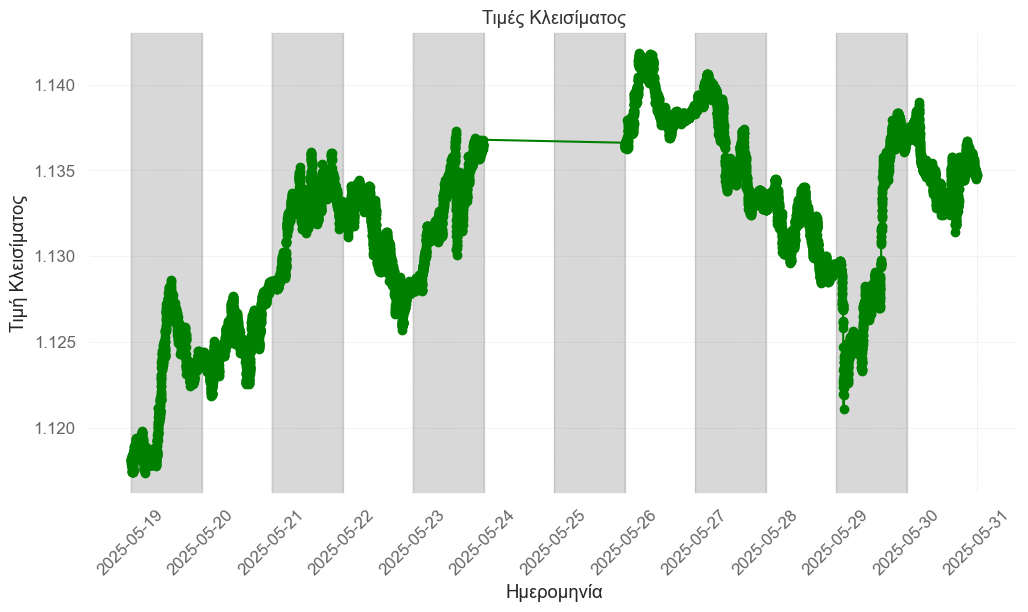

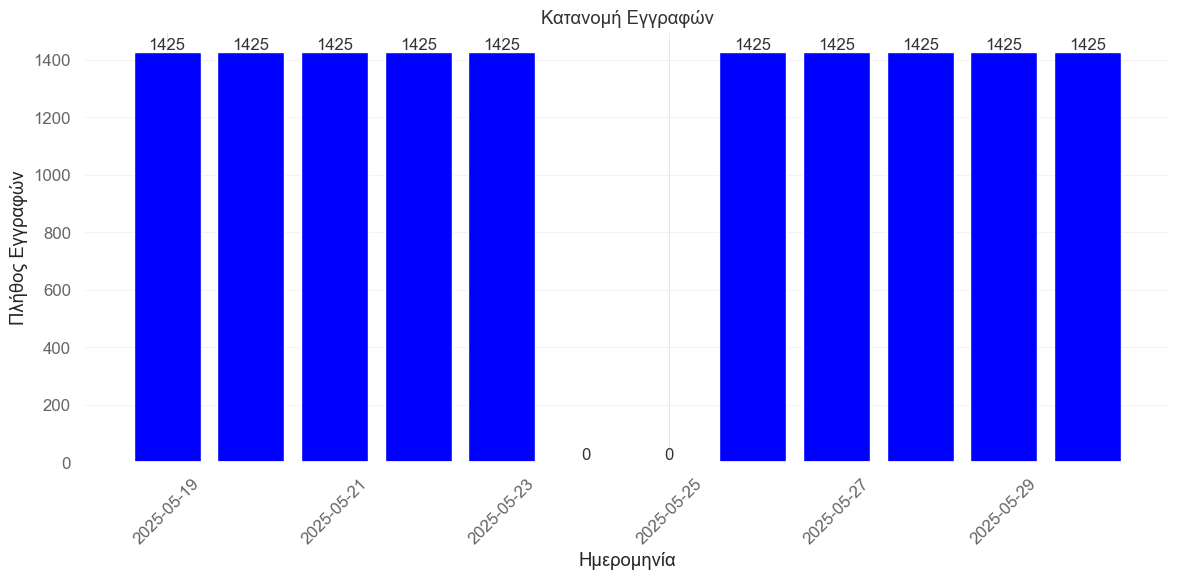

In [84]:
#### Φόρτωση δεδομένων μετοχών για την εκπαίδευση του μοντέλου ####
file_path = 'EURUSD_01.csv'  
stock_df = load_stock_data(file_path)
stock_df.index = stock_df.index + pd.Timedelta(hours=3)  # Προσαρμογή ώρας UTC+3

train_start, train_end, test_start, test_end = get_train_test_weeks()

# Διάστημα χωρίς δειγματοληψία
stock_data_period_0 = get_stock_data_for_period(stock_df, train_start, test_end, 1)
print("Πλήθος τιμών χωρίς δειγματοληψία:", stock_data_period_0.size // 5)

# Γραφική παράσταση τιμών μετοχών και κατανομής εγγραφών
plot_stock_prices(stock_data_period_0)
plot_records_distribution(stock_data_period_0)

[Info] Χρήση policy_kwargs: {'net_arch': [128, 128]}
[Info] Εκπαίδευση μοντέλου με {'learning_rate': 0.000265, 'n_steps': 256, 'batch_size': 32, 'gamma': 0.973832, 'gae_lambda': 0.818521, 'clip_range': 0.144761, 'ent_coef': 0.000979, 'policy_kwargs': {'net_arch': [128, 128]}}
[Info] Βρέθηκε προηγούμενο μοντέλο: model_20_1_30.zip
[Train] shorts=42, longs=42, profit=1.01, accuracy=0.67
[Test] shorts=30, longs=30, profit=0.99, accuracy=0.68


<Figure size 800x300 with 0 Axes>

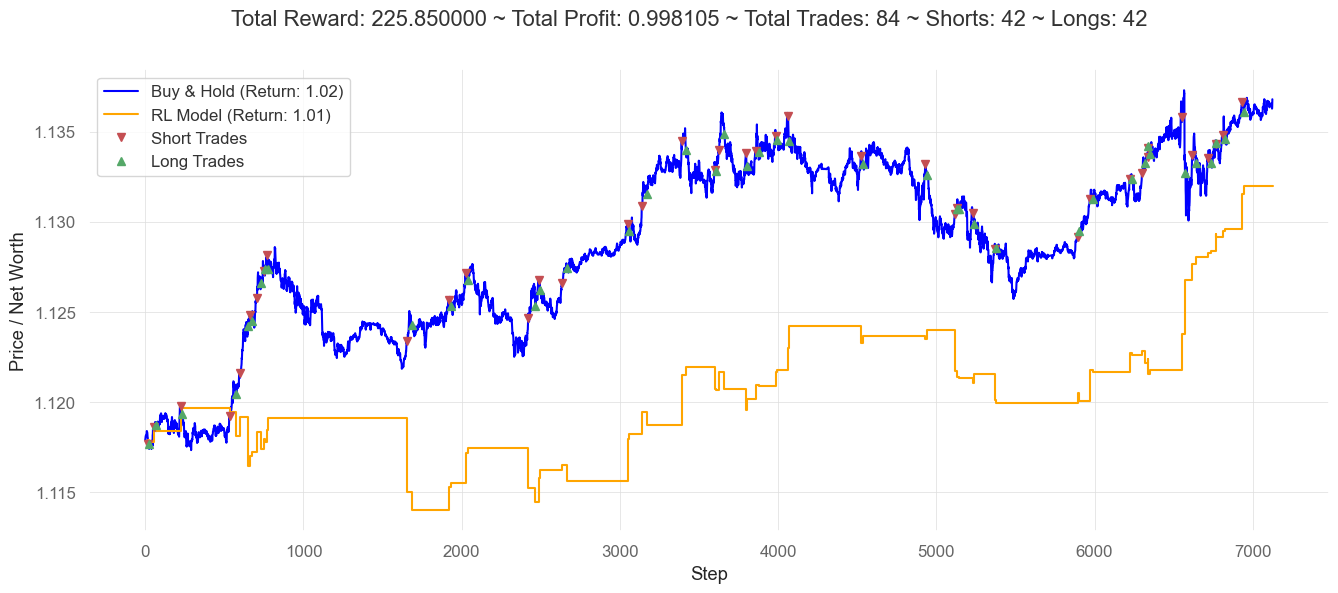

Actual Decisions:
Good shorts: 25, Bad shorts: 17
Good longs: 31, Bad longs: 11
Total Actual Trades: 84 ~ Shorts: 42 ~ Longs: 42
Calculated Total Profit: 1.0126188950117838
Environment Total Profit: 0.9981051792827578
                    Strategy
------------------  ----------
Start Period        2025-05-19
End Period          2025-05-23
Risk-Free Rate      0.0%
Time in Market      2.0%

Cumulative Return   1.26%
CAGR﹪              120.34%

Sharpe              0.26
Prob. Sharpe Ratio  91.03%
Sortino             0.38
Sortino/√2          0.27
Omega               1.53

Max Drawdown        -0.51%
Longest DD Days     3

Gain/Pain Ratio     1.82
Gain/Pain (1M)      -

Payoff Ratio        1.03
Profit Factor       1.53
Common Sense Ratio  -
CPC Index           0.94
Tail Ratio          -
Outlier Win Ratio   0.0
Outlier Loss Ratio  -0.0

MTD                 1.26%
3M                  1.26%
6M                  1.26%
YTD                 1.26%
1Y                  1.26%
3Y (ann.)           120.34%
5Y

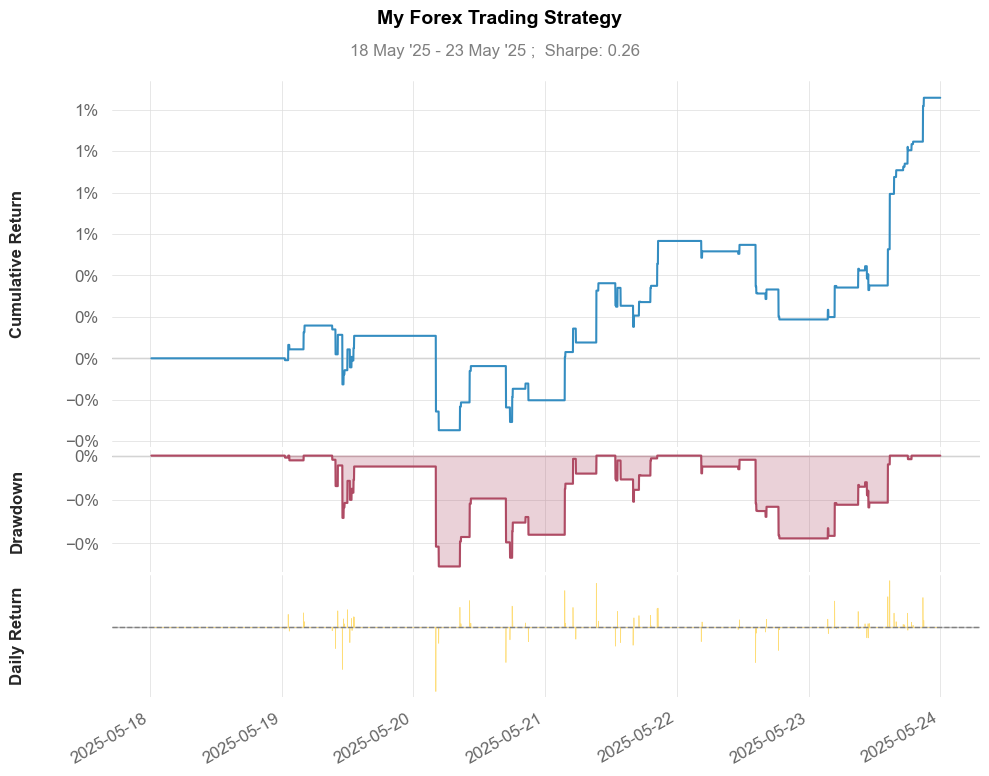

Classification Report: Predicting Trade Direction (Short vs Long)
              precision    recall  f1-score   support

       Short       0.60      0.69      0.64        36
        Long       0.74      0.65      0.69        48

    accuracy                           0.67        84
   macro avg       0.67      0.67      0.66        84
weighted avg       0.68      0.67      0.67        84



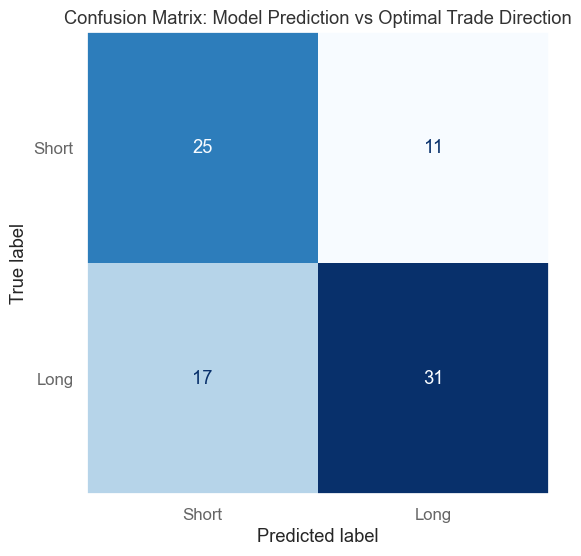

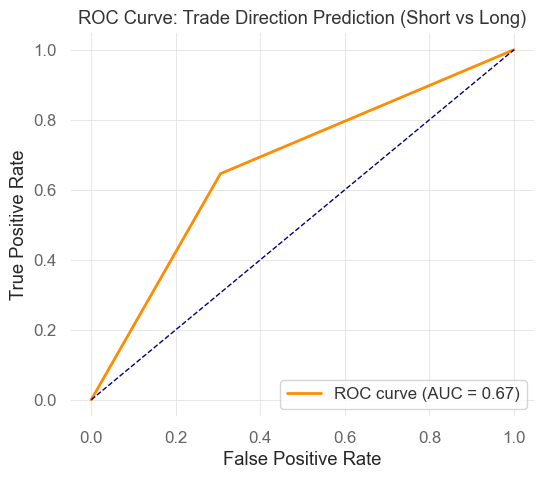

<Figure size 800x300 with 0 Axes>

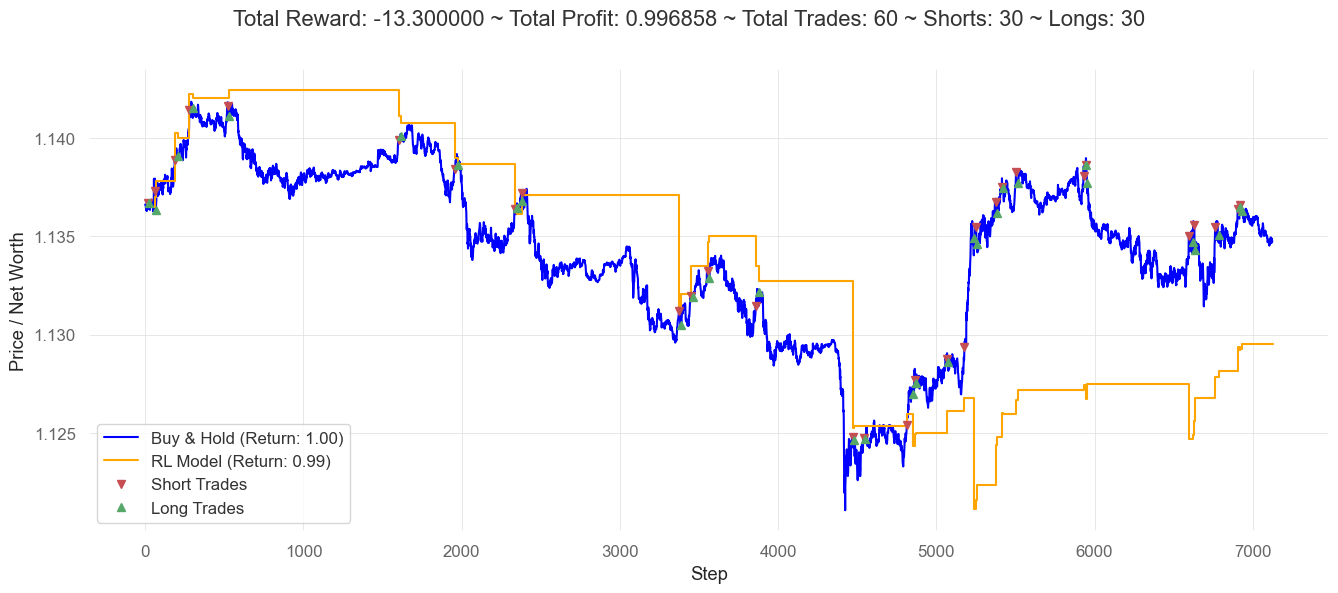

Actual Decisions:
Good shorts: 19, Bad shorts: 11
Good longs: 22, Bad longs: 8
Total Actual Trades: 60 ~ Shorts: 30 ~ Longs: 30
Calculated Total Profit: 0.9937419681333147
Environment Total Profit: 0.996857871634459
                    Strategy
------------------  ----------
Start Period        2025-05-26
End Period          2025-05-30
Risk-Free Rate      0.0%
Time in Market      1.0%

Cumulative Return   -0.63%
CAGR﹪              -32.67%

Sharpe              -0.1
Prob. Sharpe Ratio  28.12%
Sortino             -0.11
Sortino/√2          -0.08
Omega               0.79

Max Drawdown        -1.86%
Longest DD Days     4

Gain/Pain Ratio     -0.46
Gain/Pain (1M)      -1.0

Payoff Ratio        0.48
Profit Factor       0.79
Common Sense Ratio  -
CPC Index           0.24
Tail Ratio          -
Outlier Win Ratio   0.0
Outlier Loss Ratio  -0.0

MTD                 -0.63%
3M                  -0.63%
6M                  -0.63%
YTD                 -0.63%
1Y                  -0.63%
3Y (ann.)           

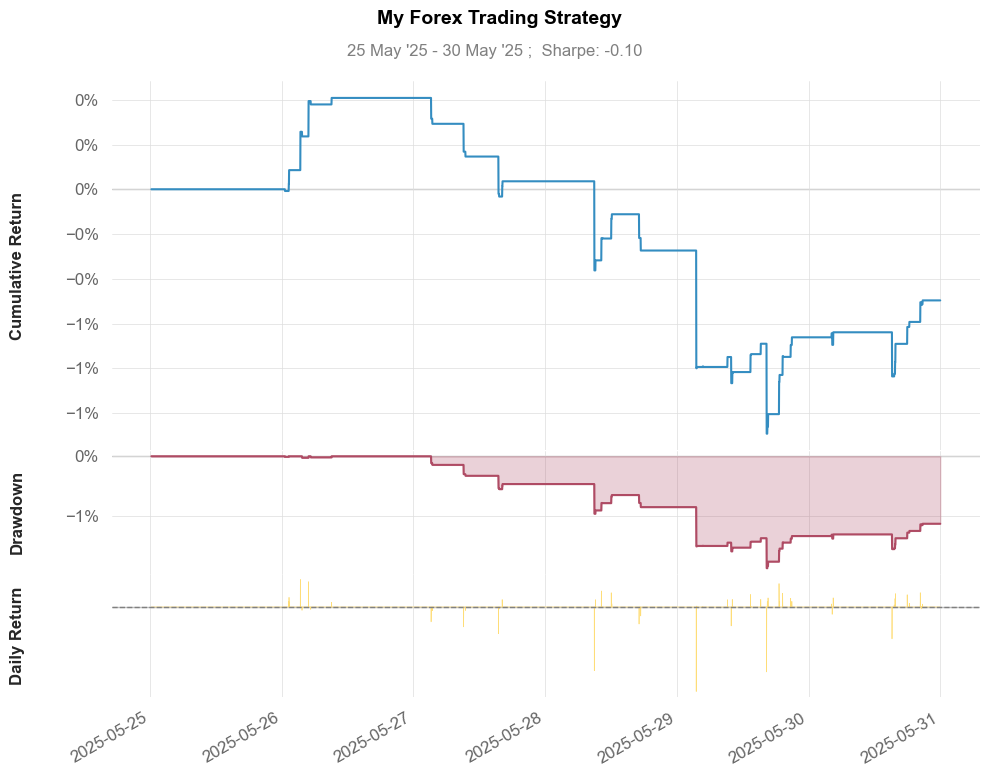

Classification Report: Predicting Trade Direction (Short vs Long)
              precision    recall  f1-score   support

       Short       0.63      0.70      0.67        27
        Long       0.73      0.67      0.70        33

    accuracy                           0.68        60
   macro avg       0.68      0.69      0.68        60
weighted avg       0.69      0.68      0.68        60



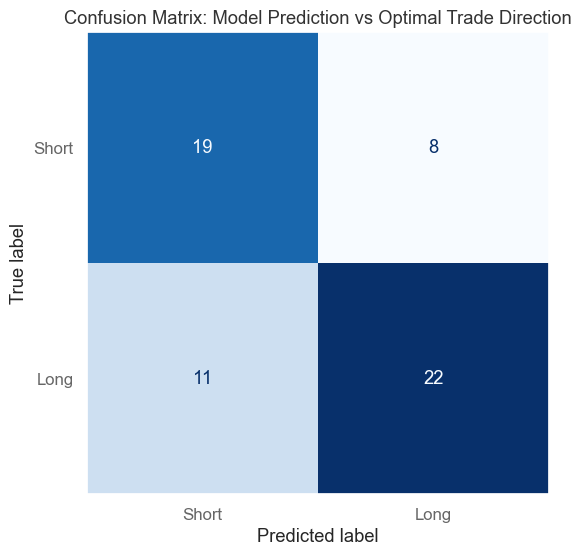

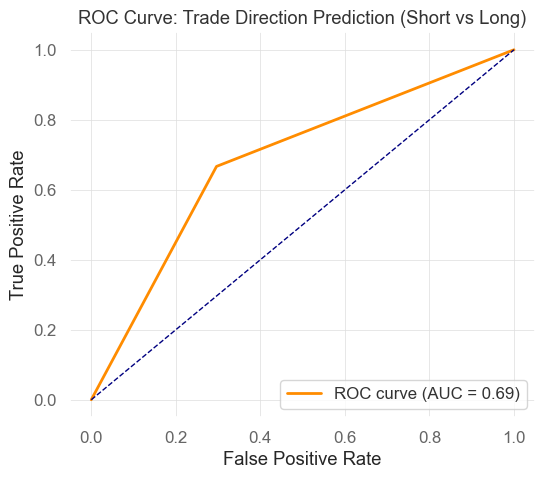

In [72]:
# --- Ρυθμίσεις ---
frequency = 1
window_size = 20
trade_fee = 0.0001
timesteps = 30
selected_features = ['momentum_pvo_signal', 'momentum_ppo_signal', 'momentum_ppo']

# Υπερπαράμετροι
ppo_params = {
    "learning_rate": 0.000265,
    "n_steps": 256,
    "batch_size": 32,
    "gamma": 0.973832,
    "gae_lambda": 0.818521,
    "clip_range": 0.144761,
    "ent_coef": 0.000979
}

# policy architecture
net_arch = [128, 128]
ppo_params["policy_kwargs"] = dict(net_arch=net_arch)

train_start, train_end, test_start, test_end = get_train_test_weeks()
train_df = get_stock_data_for_period(stock_df, train_start, train_end, frequency)
test_df = get_stock_data_for_period(stock_df, test_start, test_end, frequency)

train_df = add_all_ta_features(train_df.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
test_df = add_all_ta_features(test_df.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Εκπαίδευση
model, env = train(
    stock_df=train_df,
    start_date=train_start,
    end_date=train_end,
    frequency=frequency,
    timesteps=timesteps,
    window_size=window_size,
    trade_fee=trade_fee,
    features=selected_features,
    ppo_params=ppo_params
)

# Αξιολόγηση στο train
train_env, shorts, longs, train_profit, train_accuracy = evaluate(
    model=model,
    df=train_df,
    window_size=window_size,
    trade_fee=trade_fee,
    features=selected_features
)
print(f"[Train] shorts={shorts}, longs={longs}, profit={train_profit:.2f}, accuracy={train_accuracy:.2f}")

# Αξιολόγηση στο test
test_env, shorts, longs, test_profit, test_accuracy = evaluate(
    model=model,
    df=test_df,
    window_size=window_size,
    trade_fee=trade_fee,
    features=selected_features
)
print(f"[Test] shorts={shorts}, longs={longs}, profit={test_profit:.2f}, accuracy={test_accuracy:.2f}")

plt.figure(figsize=(8, 3))
my_render(train_env, train_df)
plt.show()

plt.figure(figsize=(8, 3))
my_render(test_env, test_df)
plt.show()
